# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0
 -1.0
 -1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0

### We create a function to visualize the data

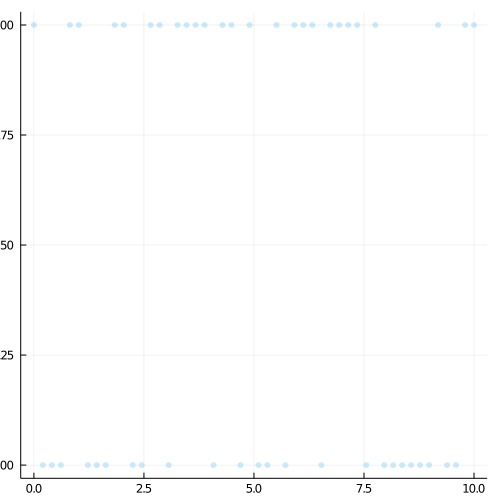

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.544133 seconds (1.15 M allocations: 67.480 MiB, 99.33% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:17
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:11
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:27
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:05
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:25
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:23
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:21
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.045361988406015796, -0.6557560864754512, -1.1220063667916573, -1.42768320864782, -1.5597430653789817, -1.462478846820284, -1.261526671529508, -0.9836993269437817, -0.7164752246794559, -0.48314614665137545  …  -1.1831572848420253, -1.320629048738995, -1.4163423526389807, -1.4157292173355727, -1.287410257920604, -1.0274315752491405, -0.6647506535096949, -0.1862060682779038, 0.30348909101063143, 0.7905365666259392]]
 [[-0.11143531814925572, 0.017830595950451278, 0.033717948320029, -0.07868773042847949, -0.21247720865294903, -0.3021629488156671, -0.36783512667994067, -0.40964218433739624, -0.36394317573121876, -0.25604205872506636  …  -0.27241065661923236, -0.2020096788500878, -0.1946971360594396, -0.1969548607898941, -0.23251195215449716, -0.22524345914672916, -0.19995488614984802, -0.09178102120694348, 0.0311720701863335, 0.2174179613008908]]
 [[-0.2670398499779982, -0.4038699999875439, -0.553093027227632, -0.6200624321168902, -0.567208

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

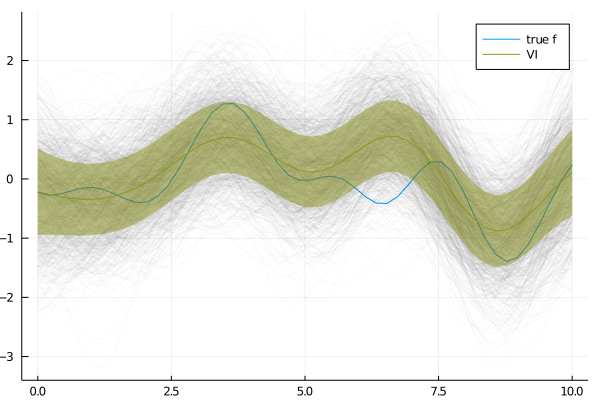

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

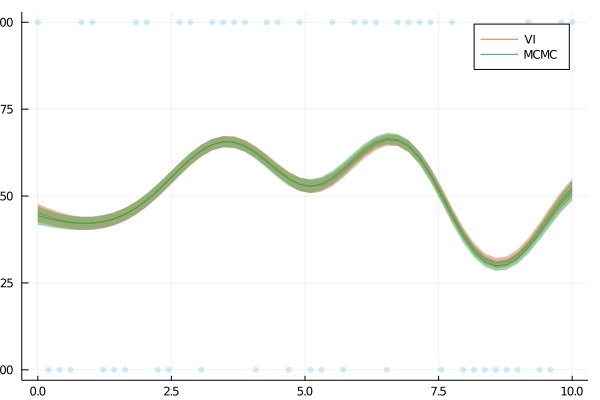

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*